In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [15]:
# Main functions definition
# Function to select only positive or negative values of a standard normal gaussian
def selectBySign(sample, sign):
	"""
	Select draw based of conditional gaussian
    :param sample: Sample to be used as the mean of the Gaussian (real)
    :param sign: Can take values "+" or "-" if the sign is +, the below flag is true. Else, is
        is false (string)
    :return: draw with the desired sign (real)
    """
	positiveFlag = sign == "+"
	while True:
		draw = np.random.normal(sample, scale=1)
		if draw > 0 and positiveFlag:  # in case of positive gaussian
			return draw
		elif draw < 0 and not positiveFlag:  # in case of negative gaussian
			return draw

# Exponential Function Kernel Function
def sqrExpKernel(X1, X2, lam=1.0, v=1.0):
	"""
    Squared exponential kernel
    :param X1: Array of m samples and p parameters (real - mxp)
    :param X2: Array of n samples and p parameters (real - nxp)
    :param l: Characteristic length (real)
    :param v: Signal variance (real)
    :return: Array with kernel functions between the points (real - mxn)
    """
	sqrDist = np.sum(X1 ** 2, 1).reshape(-1, 1) + np.sum(X2 ** 2, 1) - 2 * X1 @ X2.T
	kernel = v * np.exp(-1 / 2 * lam ** 2 * sqrDist) + 1e-5 * np.eye(X1.shape[0])
	return kernel

# Function to sample v.
def sample_v(f, kernel, samples, a_init=2, b_init=2):
	"""
	Sample v from an inverse gamma distribution
	:param f: Array of n labels (real)
	:param kernel: Array with kernel functions (real - nxn)
	:param samples: number of samples (int)
	:param a_init: initial value of alpha parameter (int)
	:param b_init: initial value of beta parameter (int)
	:return: v parameter (real)
	"""
	b_new = (b_init + 0.5 * f.T @ np.linalg.inv(kernel) @ f)
	return np.random.gamma(a_init + samples/2, b_new**(-1))**(-1)

In [16]:
# Create test dataset
# Sample one-dimensional design matrix from uniform distribution between -1 and 1.
x = np.random.uniform(-1, 1, 100).reshape(100, 1)

# Add labels to dataset. Classify the data based on their sign
y = (x >= 0).astype(float)

# Initialize auxilliary variable z
zvec = np.zeros((100, 1))

# Initialize v
a_init = 2
b_init = 2
v = 1 / np.random.gamma(2, b_init**(-1))

In [17]:
# Initialize lists to store the updated values of v, f, z
v_buffer = [v]
f_buffer = []
z_buffer = []
samples = 10000  #number of samples to take.

# Iterate and update f, z, v variables
for i in range(samples):
	## Compute kernel and canonical parameters
	# Compute covariance matrix with latest v using square exponential kernel
	cov = sqrExpKernel(x, x, 1, v)
	# Compute updated covariance for P(F|z,Y)
	fcov = np.linalg.inv(np.linalg.inv(cov) + np.eye(100, 100))
	# Compute updated mean vector for P(F|z,Y)
	fmean = np.dot(fcov, zvec)
	## UPDATE F
	# Sample from the multivariate normal for P(F|z,Y).
	f_samples = np.random.multivariate_normal(fmean.flatten(), fcov, 1).T
	f_buffer.append(f_samples)

	## UPDATE Z
	zz = np.zeros(100)
	for i in range(100):
		if y[i] == 0:
			# Sample from conditional P(z_i|f_i,Y=0)
			val = selectBySign(f_samples[i], "-")
			zvec[i] = val
			zz[i] = val
		else:
			# Sample from conditional P(z_i|f_i,Y=1)
			val = selectBySign(f_samples[i], "+")
			zvec[i] = val
			zz[i] = val

	# Add z vector to the buffer
	z_buffer.append(zz)
	## UPDATE V
	v = sample_v(f_samples, cov, samples)
	v_buffer.append(v)  #add v to the buffer

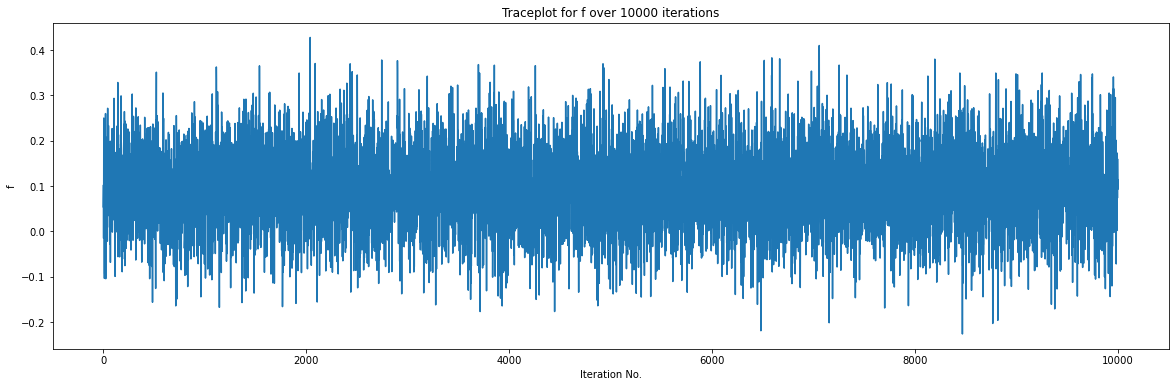

In [56]:
plt.rcParams["figure.figsize"] = (20,6)

# Plot the traceplot for a given f
sample = 2
f = np.stack(f_buffer)
plt.plot(f[:, sample])
plt.title("Traceplot for f over 10000 iterations")
plt.xlabel("Iteration No.")
plt.ylabel("f")
# plt.savefig("traceplot_f")
plt.show()

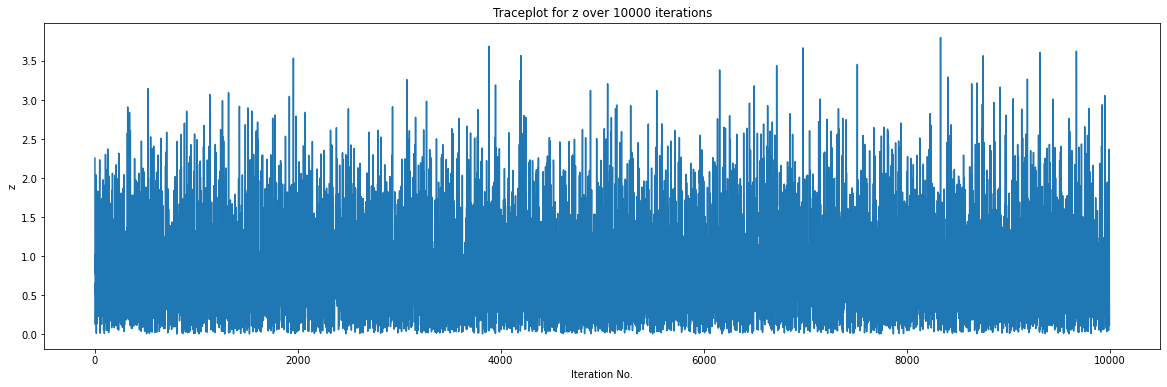

In [54]:
# Plot the traceplot for a given z
sample = 2
z = np.stack(z_buffer)
plt.plot(z[:, sample])
plt.title("Traceplot for z over 10000 iterations")
plt.xlabel("Iteration No.")
plt.ylabel("z")
# plt.savefig("traceplot_z")
plt.show()

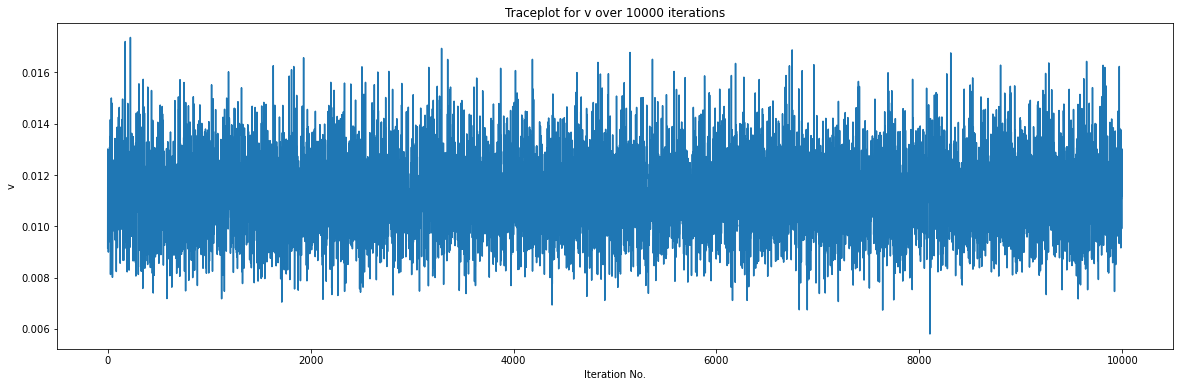

In [55]:
# Plot the traceplot for v
v = np.stack(v_buffer[1:])[:, 0, 0]
plt.plot(v)
plt.title("Traceplot for v over 10000 iterations")
plt.xlabel("Iteration No.")
plt.ylabel("v")
# plt.savefig("traceplot_v")
plt.show()


In [ ]:
v
